# 1. Downloading the dataset

In this study, we use the [Xeno-Canto](https://xeno-canto.org/) sound library, a collaborative project dedicated to sharing bird sounds from all over the world. We focus on the European Greenfinch (Chloris Chloris) bird specie. The song of a male *Chloris Chloris* has been characterized by having groups of tremolos, repetitions of tonal units, nasal chewlee and a buzzing nasal wheeze, which could be uttered on its own ([Cramp & Perrins, 1994](https://www.biblio.com/9780198546795)). [Güttinger (1977)](https://www.jstor.org/stable/4533805?seq=1), similarly to Cramp & Perris (1994), identified four phrases classes (short groupings of syllables sharing the same or similar shape): 

- a trill 
- a pure tone 
- a nasal tone 
- a nasal “tswee”

Moreover, [Güttinger (1977)](https://www.jstor.org/stable/4533805?seq=1) argues that the size of the repertoire can be determined by the number of phrases, where, most phrases of the *Chloris Chloris*, or short group of syllables, are repeated after identical intervals, for a period, on the average, which lasts 0.5 seconds. Based on these observations, we propose to use Machine Learning techniques to design an unsupervised system able to estimate the size of the repertoire of the *Chloris Chloris*. The proposed system receives as input a set of audio time series data that we will downloaded from the Xeno-Canto's sound library which are segmented and converted into a reduced representation set called a feature vector. Feature vector has the ability of discriminating among classes and is used to characterize the size of the bird song syllable repertoire. The system is evaluated using clustering performance metrics to find the ideal number of syllables in the data set.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Create folders to download the data set

In [2]:
directory = "data"
records = "recordings"
# Path
path = os.path.join(os.getcwd(), directory)
os.mkdir(path)
path = os.path.join(path, records)
os.mkdir(path)

Now, we can start generating a list of bird recordings using the Xeno Canto's web API in order to build our data set. You can find more information on the data used for this study by checking the Xeno Canto [Application Programming Interface (API v2)](https://xeno-canto.org/explore/api) documentation. In the API, some species have multiple number of pages in their recording lists. You can tell if this is the case based on whether the *numPages* is greater than 1. If that is the case, you won't get all of the records unless you specifically go to the next page. In our case, there are 2 pages. We can then check the recording list by visiting online. Also, we use the [wget](https://en.wikipedia.org/wiki/Wget) computer program to retrieve the content (technically a `json` file) from the Xeno Canto's web API and save it to the data folder. After that, we create a `csv` and `txt` file from the `json` file which is used to download the recordings. Moreover, we use an area-based query gathering European recordings of the Chloris Chloris. We select only high quality recordings according to the Xeno-Canto quality ratings ranging from A (highest quality) to E (lowest quality) 5 and remove recordings containing more than one other bird species in order to avoid misinterpretation. This is done by checking the `also` column of the dataframe. 

Finally, we use the [wget](https://en.wikipedia.org/wiki/Wget) computer program to download the recordings and save them in their respective folder.

In [3]:
def handling_json(json_file):
    # Get the json entries from the downloaded json file
    jsonFile = open(json_file, 'r')
    values = json.load(jsonFile)
    jsonFile.close()

    # Create a pandas dataframe of records & convert to .csv file
    path, ext = os.path.splitext(json_file)
    record_df = pd.DataFrame(values['recordings'])
    
    # Remove recordings with other bird species
    other_birds = []
    for i in range(len(record_df.index)):
        if len(list(filter(None, record_df['also'][i]))) != 0:
            other_birds.append(i)
    record_df = record_df.drop(other_birds)    
    record_df.to_csv(path + '.csv', index=False)   

    # Make wget input file
    urls = []
    for file in record_df['file'].tolist():
        urls.append(file)
    with open(path + '.txt', 'w+') as f:
        for item in urls:
            f.write("{}\n".format(item))
            
    # Remove JSON temporary file
    os.remove(json_file)

# Create temporary files and download dataset
area = "europe"
numPages = 2

for i in range(1, numPages+1):
    cmd = f'wget -O "./data/{area}_temp{i}.json" "https://xeno-canto.org/api/2/recordings?query=chloris+area:{area}+q:a&page={i}"'    
    os.system(cmd)
    # Handling JSON files to create CSV and TXT files
    json_file = f"./data/{area}_temp{i}.json"
    handling_json(json_file)
    cmd = f'wget -P "./data/recordings" --trust-server-names -i "./data/{area}_temp{i}.txt"'
    os.system(cmd)

Finally, we can remove the temporary files and check each `csv` files making sure that no files are missing.

In [4]:
print('Checking for missing files...')
# Concatenate csv files
df1 = pd.read_csv(f'./data/{area}_temp1.csv')
df2 = pd.read_csv(f'./data/{area}_temp2.csv')
df = pd.concat([df1,df2])

# Checking for missing files
print(f'Number of european recordings before checking: {df.shape[0]}')
notfoundid = []
for idx, row in df.iterrows():
    if row['file-name'] not in os.listdir('./data/recordings'):
        notfoundid.append(idx)
df = df.drop(notfoundid) # removing missing audio file
print(f'Number of european recordings after checking: {df.shape[0]}\n')

# Remove temp files
for i in range(1, numPages+1): 
    os.remove(f"./data/{area}_temp{i}.csv")
    os.remove(f"./data/{area}_temp{i}.txt")

Checking for missing files...
Number of european recordings before checking: 339
Number of european recordings after checking: 339



After downloading is complete, we can remove the columns which are not important for our study and store the dataset in a new `csv` file.

In [5]:
print("Saving csv file...")
# Keep only the columns of interest
df = df[['id','gen','en','cnt','type','file-name','length']]
# Store dataset csv file
df.to_csv('dataset.csv', index=False)
print('Done!')

Saving csv file...
Done!


Furthermore, we can plot the distribution of the audio recordings according to the European countries were they were recorded and calculate the mean duration of an audio recording.

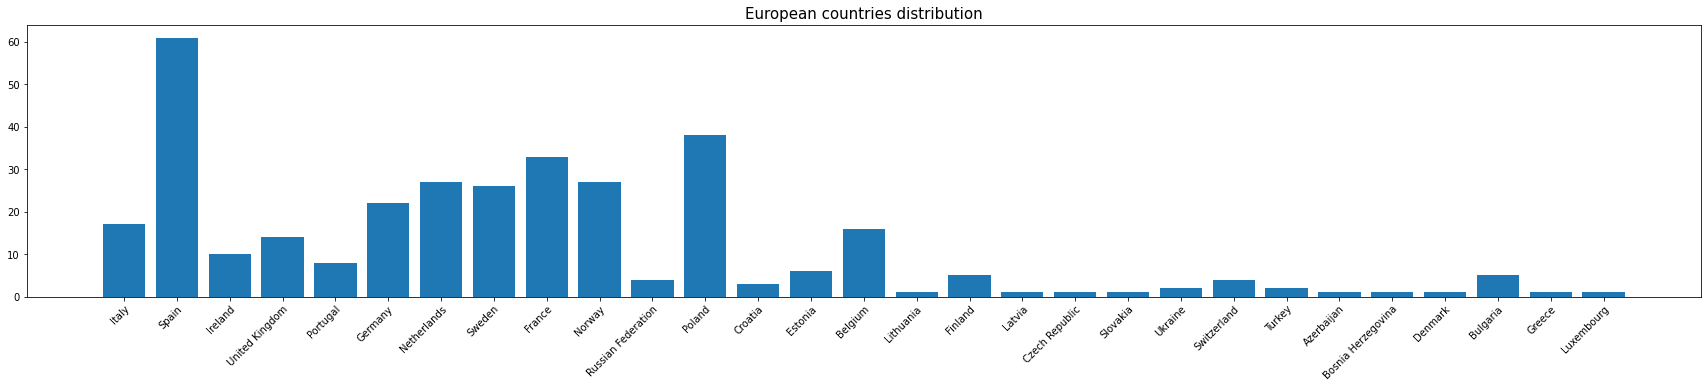

In [8]:
distribution = []
unique = pd.unique(df['cnt'])
for i in unique:
        distribution.append(len(df[df['cnt'] == i]))

fig, ax = plt.subplots(figsize=(30,5))
ax.set_title('European countries distribution', size=15)
ax.bar(np.arange(len(unique)), distribution)
ax.set_xticks(np.arange(len(unique)), labels=list(unique))
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor");

In [36]:
duration = np.mean([float(i.replace(":", ".")) for i in df['length']])
print(f'Mean duration of an audio recording: {round(duration*60,2)} seconds')

Mean duration of an audio recording: 48.64 seconds
